#### 构建一个可迭代的类来模拟一个村庄中，农民与工匠间的贸易：

基本假设：村民们每天需要消耗1份粮食，农民如果每天全部时间种田可以产出 5  份粮食 # 并需要消耗一份工具(消耗量按产量变化未实装)。
   同理，村民们每天需要消耗1份工具，裁缝如果每天全部时间织布可以产出10 份工具
       村民们每天需要消耗1份衣物，裁缝如果每天全部时间织布可以产出 5 份衣物

假设每个职业都能生产别的商品，只是效率较低。我们可以给出生产效率矩阵(单位：产量/天)

裁缝：[2.5, 2.5, 5]；

农民：[5, 3.3, 3.3]；

工匠：[2.6, 10, 2.5]。

对上述模型稍加推广，令每个村民都具有如下属性：

  生产属性，即生产效率矩阵；
  
  消耗属性，每日消耗的产品份数；
  
  生产耗时，在生产某种产品上消耗的时间；
  
  贸易量，各商品的卖出，买入份数；
  
  库存状态，每天的(生产-消耗+贸易)量将被加入其中。越缺乏某种产品，越有动力去通过工作或贸易获得之。
  
先考虑不含贸易的类:
村民希望库存能满足一定天数的消耗，为此他每天消耗在某项产品上的工作时长 = 生产效率^EXP(-库存/生产效率/期望库存天数)，
   可以看到，库存越多，工作时长越短，符合朴素常识。

商品定价：每次交易计算 供需比例=(供应-需求)/(供应+需求),下次价格为 价格×EXP(供需比例)

购买行为：得知自己的优势商品后，购买所有值得的不容忍量，并希望出售等价值的商品

In [1]:
# 均值化以观察图像
import numpy as np
def moving_average(lst, k=5):
    arr = np.array(lst, dtype=float)
    n = len(arr)
    half = k // 2
    
    # 先创建一个全为原始数据的结果数组
    result = arr.copy()

    # 只在能够滑动的位置做滑动均值
    for i in np.arange(half, n - half):
        result[i] = np.mean(arr[i - half:i + half + 1])

    return result

# 画图预备包
import matplotlib.pyplot as plt
Names = ["A's ", "B's ", "C's ", "D's "];
Goods = ["food", "tools", "clothes", "meat"];
Colors = ["blue", "orange", "green", "red"];
Line_types = ["-.", "--",":","*-"];
def fun_fianl(status, x, i, j):
    return [status[y][i][j] for y in x]
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def visual(status, work_times, prices, employee, wealth, scale, k=0, names=Names, goods=Goods, colors=Colors, line_types=Line_types):
    fig = plt.figure(figsize=(11, 7))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1.2, 1])  # 上1行，下1行，比例2:1

    # 第一幅图：库存状态图，占左上两列
    ax1 = fig.add_subplot(gs[0, :-1])
    x = np.arange(len(status))
    for i in np.arange(len(status[0])):
        for j in np.arange(len(status[0][0])):
            ax1.plot(scale * x, fun_fianl(status, x, i, j), line_types[j], label=names[i] + goods[j], color=colors[i])
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Status')
    ax1.legend(loc=2)
    ax1.grid()

    # 第二幅图：工作时间图，占左下角
    ax2 = fig.add_subplot(gs[1, 0])
    y = np.array(list(map(lambda x: np.sum(x, axis=1), work_times))).T
    for i in np.arange(len(y)):
        ax2.plot(scale * np.arange(len(y[0])), moving_average(y[i], k), label=names[i], color=colors[i])
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Work Time')
    ax2.legend(loc=2)
    ax2.set_ylim(0, 1.05)
    ax2.grid()

    # 第三幅图：价格图，占右上角
    ax3 = fig.add_subplot(gs[0, 2])
    z = np.array(prices).T
#     z = z / z[0]  # 归一化
    for i in np.arange(len(z)):
        ax3.plot(scale * np.arange(len(z[0])), moving_average(z[i], k), line_types[i], label=goods[i], color="black")
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Goods Prices')
    ax3.set_ylim(bottom=0) 
    ax3.legend(loc=2)
    ax3.grid()
    
    # 第四幅图：从业者数量图，占正下方
    ax4 = fig.add_subplot(gs[1, 1])
    e = np.array(employee).T
    for i in np.arange(len(e)):
        ax4.plot(scale * np.arange(len(e[0])), moving_average(e[i],k), label=names[i], color=colors[i])
    ax4.set_xlabel('Day')
    ax4.set_ylabel('Employee')
    ax4.legend(loc=2)
    ax4.set_ylim(0, sum(employee[0]))
    ax4.grid()
    
    # 第五幅图：从业者财富图，占右下角
    ax5 = fig.add_subplot(gs[1, 2])
    w = np.array(wealth).T
    for i in np.arange(len(w)):
        ax5.plot(scale * np.arange(len(w[0])), moving_average(w[i], k), label=names[i], color=colors[i])
    ax5.set_xlabel('Day')
    ax5.set_ylabel('Wealth')
    ax5.legend(loc=2)
    ax5.grid()

    plt.tight_layout()
    plt.show()

In [2]:
import numpy as np
import copy
class IsoBlock(object): 
    def __init__(self, consumption, product_eff, status):
        """
        经济模拟系统中的独立无交易区块类。
        """
        # 读取参数，状态和工作时间
        self.consumption = np.array( consumption, dtype=float)  # 商品消耗量
        self.product_eff = np.array(product_eff, dtype=float)  # 单位时间能生产的商品量
        self.product_time = 1 / self.product_eff # 生产单位商品所需时间
        self.status = np.array(status, dtype=float)  # 库存状态

class testBlock(IsoBlock): 
    def __init__(self, consumption, product_eff, status):
        """
        经济模拟系统中的独立无交易区块类。
        """
        # 读取参数，状态和工作时间
        super().__init__(consumption, product_eff, status)
    def evolution(self, day):
        """
        经济演化过程。
        
        """
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度（即1/5的工作时间，以保证库存在-5时单人独自能达到平衡））
#         self.worktime = (-self.status * 0.2) * self.product_time
#         self.worktime[self.worktime < 0] = 0
        self.coef = (self.product_time) / day
        self.worktime = self.product_time**(self.coef * self.status)
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime * self.product_eff
        
        # 计算每日非必须品消耗（工具消耗即工作时间）
#         self.consumption[:,1] = production[:,0]
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption

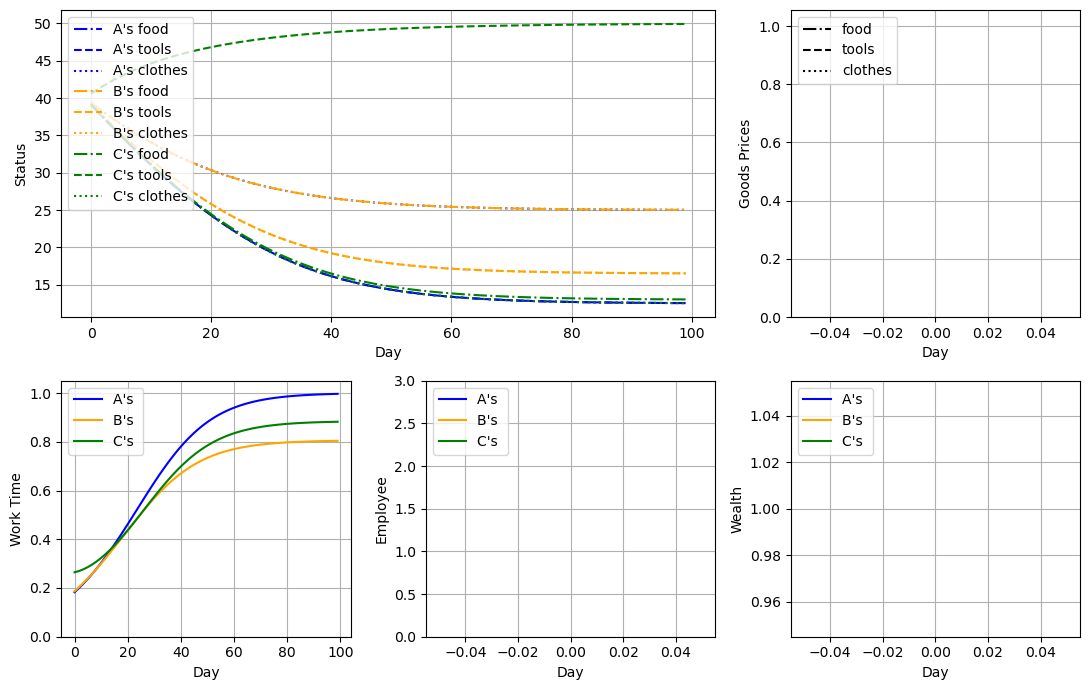

In [3]:
# 创建实例
j=3; k=3;
Status = [];
Worktimes = [];
test = testBlock( 
               np.ones([j,k]), #201,纺 农 匠
               [[2.5, 2.5, 5],[5, 3.3, 3.3], [2.6, 10, 2.5]], 
               np.ones([j,k]) * 40)
for i in range(100):
    test.evolution(5)
    Status.append(test.status)
    Worktimes.append(test.worktime),test
visual(Status, Worktimes, [[1,1,1]], [[1,1,1]], [[1,1,1]], 1)

In [86]:
import numpy as np
from collections import Counter
class TradeBlock(IsoBlock): 
    def __init__(self, consumption, product_eff, status, wealth, employee, hinder, trade_prices = 0):
        """
        经济模拟系统中的有贸易区块类。
        """
        # 读取参数，状态和工作时间
        super().__init__(consumption, product_eff, status)
        self.wealth = np.array(wealth, dtype=float) # 各职业手中的资产
        self.employee = np.array(employee, dtype=float) # 各职业从业人数
        self.hinder = np.array(hinder, dtype=float) # 职业难度，潜在转业者看到的某职业的劳动时间将乘以该难度系数
        self.trade_prices = np.array(trade_prices, dtype=float) # 商品的市场价格
        # 给出演化中不变但需要用到的常参数
        self.category = len(status[0]) # 商品种数
        self.market = np.zeros(self.category + 1) # 初始化的市场
        self.N = len(status) # 职业数
        self.x = range(self.N) # 遍历各职业的数列
        self.voidm = np.zeros_like(self.status) # 正确维度的空矩阵空矩阵
        self.expect = np.min(self.product_time, axis=0) # 各商品的最低工作时间
        self.Trade_prices = []
    
    def evolution(self, day, willing, sensitive, lazy): 
        # day: 仓储容量，day = 10即有能用10天的货物; 
        # willing: 转换工作的意愿
        # isolation: 孤立程度，用于混合按劳分配与市场分配的价格
        # lazy: 根据拥有的财富降低劳动时间
        # patient: 比较现有价格与平均价格，以修正购买欲望
        """
        经济演化过程。
        
        """
        
        # 加权供需比例作为调整价格的基数
        self.pop = sum(self.employee)
        self.trade_prices = np.exp(-self.market[:-1]/self.expect * sensitive / self.pop) # 通过各商品的最低工作时间压制相关商品的振幅
        # 计算各职业的体感价格(生产某商品时赚取单位价值所需的时间，并倾向于生产效率最高的产品)
        self.feel_price = self.product_eff * self.trade_prices
        # 找到对某职业相对最优势的商品序号
        self.choice = np.array(np.argmax(self.feel_price, axis=1),dtype=int)
        
        # 计算每日工作时间
        self.work_time = self.voidm+0
        self.work_time[self.x, self.choice] = np.exp(-self.product_time[self.x, self.choice] * self.wealth * lazy) # 财富越多工作越少
        self.work_time = self.work_time
        self.work_time[self.work_time < 0.01] = 0 # 生产时间很少时直接不生产
        self.stop = np.sum(self.work_time, axis=1)
        self.stop[self.stop < 1] = 1
        self.work_time = np.diag(1 / self.stop) @ self.work_time# 生产时间不能超过一整天
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间 × 从业人数修正
        self.production = np.diag(self.employee) @ self.product_eff * self.work_time
        
        # 计算每日非必须品消耗（工具消耗即工作时间） 
#         self.consumption[:,1] = production[:,0] #由于种田消耗工具将导致种田成本变化，影响优势商品的选取，故先不实装以测试平衡

        #计算各职业每日拟购买的各商品量
        #需要所有商品，库存越多想买的越少，平衡于仓储容量，并加入从业人数修正
        self.needs = np.diag(self.employee) @ (np.exp(-self.status / day  + 1) - np.exp(self.status / day - 1))
        #买卖都在市场中进行
        self.market[:-1] -= np.sum(self.needs, axis=0)
        
        # 计算新库存状态：旧库存 - 消耗 + 生产 + 贸易变化
        self.status = self.status - self.consumption + np.diag(1 / self.employee) @ (self.production + self.needs)
        # 计算货币流动
        self.exchange = - np.sum(self.needs * self.trade_prices, axis=1)
        self.market[-1] += -sum(self.exchange)
        self.wealth += self.exchange @ np.diag(1 / self.employee)

        #职业转换：各职业都向其他所有职业转化，转化速度与工作时间呈反比，并加入困难系数增加流出人口
        self.trans = np.zeros([self.N, self.N])
        # 计算总劳动负担（每个职业的工作时间总和）
        self.loading = np.sum(self.work_time, axis=1) * self.hinder
        self.preloading = self.loading + 0
        diff = self.loading * self.hinder # 潜在转业者感受到的某职业的体感劳动时间
        for i in range(self.N):
            self.trans[i] = - self.loading + self.loading[i] # 观察哪个职业工作时间相对更少
            self.trans[i][self.trans[i] < 0] = 0 # 不去（看上去）更累的地方
            self.trans[i, i] = -sum(self.trans[i]) # 计算流出人口
            self.trans[i] = self.trans[i] * willing * self.employee[i]**2 / sum(self.employee) #计算从该职业出发的人口变化
        self.trans = (self.trans.T + np.diag(self.employee)) # 第i行j列即行业i从行业j接收到的人数（且被归一）
        self.prestatus = self.status
        self.status = np.diag(1 / self.employee) @ self.trans @ self.status # 库存转移
        self.employee = np.sum(self.trans, axis=1) # 新的雇员人数       
        self.wealth = self.wealth @ self.trans.T @ np.diag(1 / self.employee) # 财产转移

In [125]:
# 创建实例
from tqdm.notebook import tqdm
j=4; k=4;
Status = [];
Work_times = [];
Prices = [];
Wealth = [];
Employee = [];
# self = TradeBlock( 
#                np.ones([2,3]), #201,纺 农 匠
#                [[2.5, 2.5, 6],[5, 3.3, 3.3]], 
# #                [[2,2,7],[7,2,2],[2,7,2]],
#               np.ones([2,3]),
#                np.ones(2),
#                [1,0.8],
#                [1, 1])

self = TradeBlock( 
               np.ones([j,k]), #201,纺 农 匠
#                [[2.5, 2.5, 6], [2, 10, 2.5],[5, 2.3, 2.3]], 
               [[20, 4, 4, 2], [4, 16, 4, 2], [4, 4, 12, 2], [4, 4, 4, 6]],
#                [[0.2,0.2,7],[7,0.2,0.2],[0.2,7,0.2]],
               np.ones([j,k])*15,
               np.ones(j)*50,
               [1, 1, 1, 1],
               [1.2, 1, 1, 1])

  0%|          | 0/3000 [00:00<?, ?it/s]

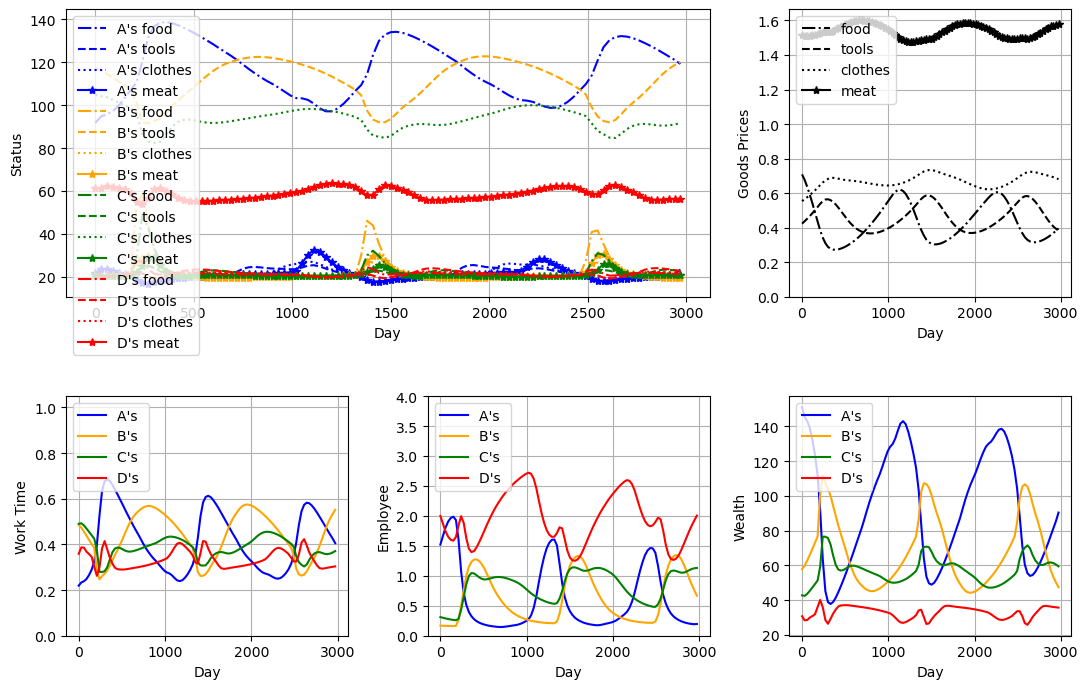

In [132]:
period = 3000
import numpy as np
def uniform_sample(data, num_samples=100):
    num_samples = min(num_samples, len(data))
    indices = np.linspace(0, len(data) - 1, num_samples, dtype=int)
    return [data[i] for i in indices]

for i in tqdm(range(period)): #day, work_time reaction, loading feeling, change job willing, market sensitive, isolation, lazy, storage
    self.evolution(40,  # day
                   0.05,# change job willing
                   0.0001,# market sensitive
                   0.2,# lazy
                  )
    Status.append(self.status+0)
    Work_times.append(self.work_time+0)
    Prices.append(self.trade_prices+0)
    Wealth.append(self.wealth+0)
    Employee.append(self.employee+0)
sampled_inputs = list(map(uniform_sample, [Status[-period:], Work_times[-period:], Prices[-period:], Employee[-period:], Wealth[-period:]]))
visual(*sampled_inputs,period / 100)

雇佣数量加权后的各职业平均劳动时间

In [90]:
total_worktime = np.array(np.sum(Work_times[-period:],axis=1)) * np.array(Employee[-period:])
np.sum(total_worktime[-period:],axis=0) / np.sum(Employee[-period:],axis=0)

array([0.30636192, 0.3619892 , 0.3526458 , 0.36323386])

In [91]:
self.trade_prices

array([0.62160362, 0.53238935, 0.68225888, 1.42845439])

In [92]:
np.mean(Prices[-period:], axis=0)

array([0.5404887 , 0.56315408, 0.76469666, 1.39569131])

In [93]:
m_loading = np.mean(np.array(list(map(lambda x: np.sum(x, axis=1), Work_times[-period:]))),axis=0)
m_loading

array([0.32119815, 0.37406595, 0.36353365, 0.39187741])

In [94]:
self.market

array([ 1900.60094855,  3154.21644626,  2549.02587759, -4754.78717459,
        -262.146889  ])

In [95]:
np.mean(Employee[-period:],axis=0)

array([0.70394219, 0.78086281, 1.04489653, 1.47029846])

In [96]:
np.mean(Work_times[-period:],axis=0)

array([[0.32119815, 0.        , 0.        , 0.        ],
       [0.        , 0.37406595, 0.        , 0.        ],
       [0.        , 0.        , 0.36353365, 0.        ],
       [0.        , 0.        , 0.        , 0.39187741]])

In [97]:
sum(self.wealth@np.diag(self.employee))+self.market[-1]

200.00000000000392

In [98]:
# 参数检查
for attr, value in vars(self).items():
    print(f"{attr} = {value}")

consumption = [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
product_eff = [[20.  4.  4.  2.]
 [ 4. 16.  4.  2.]
 [ 4.  4. 12.  2.]
 [ 4.  4.  4.  6.]]
product_time = [[0.05       0.25       0.25       0.5       ]
 [0.25       0.0625     0.25       0.5       ]
 [0.25       0.25       0.08333333 0.5       ]
 [0.25       0.25       0.25       0.16666667]]
status = [[26.44254907  5.31969475  5.33306024  5.34914035]
 [ 5.18905079 26.58025274  5.20562649  5.19487033]
 [ 5.16693694  5.16693694 23.97920024  5.16693694]
 [ 5.17705529  5.17705529  5.18582971 16.05045284]]
wealth = [241.98867998 155.13295076 109.41607286  57.69812621]
employee = [0.46894185 1.04183822 0.83958295 1.64963698]
hinder = [1.2 1.  1.  1. ]
trade_prices = [0.62160362 0.53238935 0.68225888 1.42845439]
category = 4
market = [ 1900.60094855  3154.21644626  2549.02587759 -4754.78717459
  -262.146889  ]
N = 4
x = range(0, 4)
voidm = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
expect = [0.05   